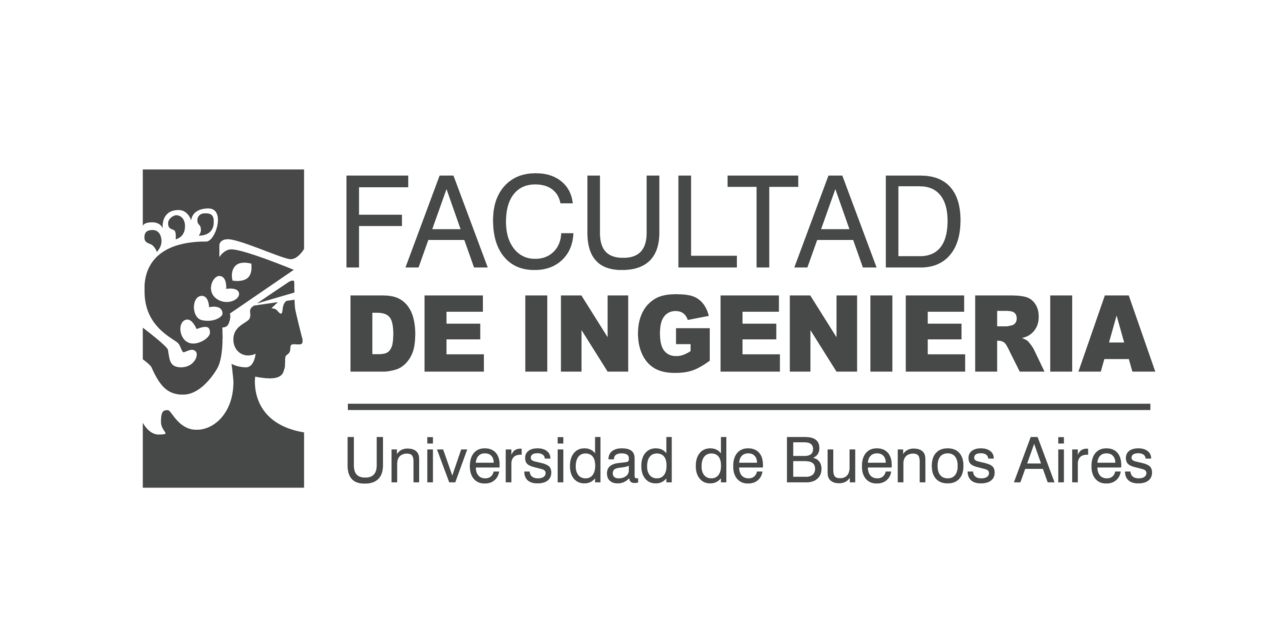

**Profesor:** <br />
Dr. Ing. Facundo Adrián Lucianna

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/IIA-TP3 <br />


## TP3: Detector de SPAM

### Consigna

Uno de los problemas más comunes en la clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo. La detección de SPAM es un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para eludir los filtros de correo no deseado. Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado una variedad de técnicas más avanzadas en la detección de SPAM, que incluyen algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico, utilizaremos un conjunto de datos que consta de 4601 observaciones de correos electrónicos, de los cuales 2788 son correos legítimos y 1813 son correos SPAM. Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo de alguna manera. Para este conjunto de datos, ya se ha aplicado un procesamiento típico en el Procesamiento del Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural (NLP) desempeña un papel fundamental en la detección de SPAM, ya que permite analizar el contenido de los correos electrónicos y extraer características relevantes para la clasificación. Además de contar la frecuencia de palabras, se pueden utilizar técnicas más sofisticadas, como la extracción de características semánticas y el análisis de sentimientos, para mejorar la precisión de los modelos de detección de SPAM.

En este proceso, se cuenta la cantidad de ocurrencias de cada palabra en los diferentes correos.

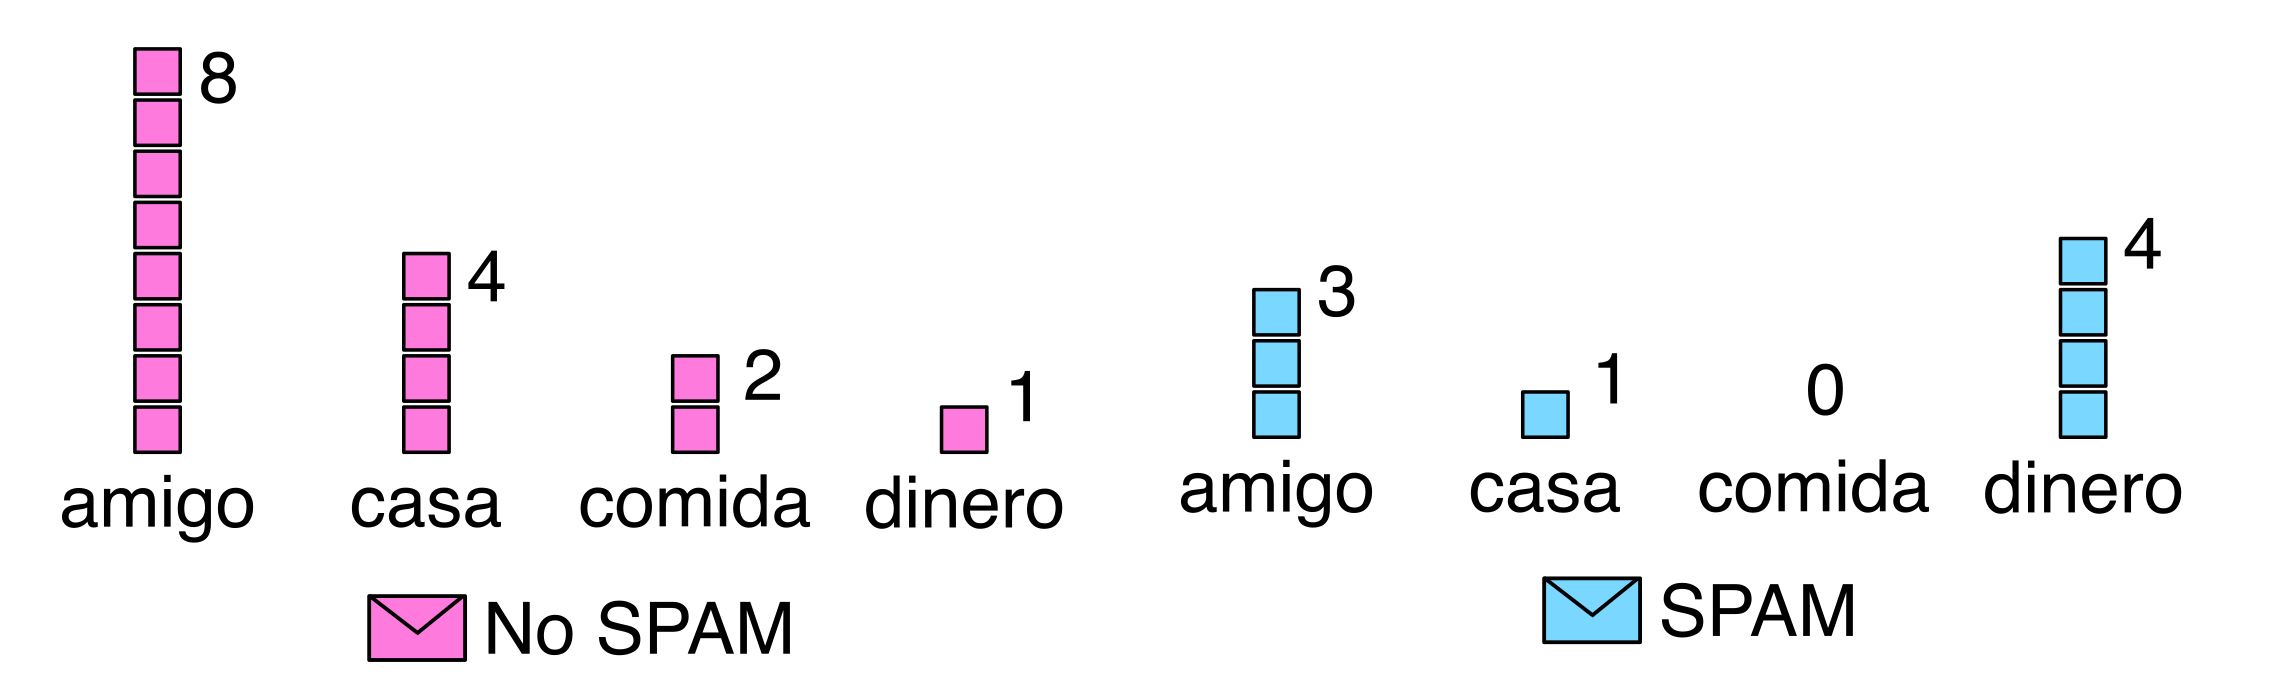

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras se encuentra normalizada. El conjunto de datos está compuesto por 54 columnas de atributos que se denominan:

- `word_freq_XXXX`: Donde `XXXX` es la palabra o símbolo. Los valores son enteros que van de 0 a 20k.

Además, hay una columna adicional llamada `spam`, que es 1 si el correo es SPAM o 0 si no lo es.

Los clasificadores de Bayes ingenuos fueron los primeros filtros utilizados por las aplicaciones de correo electrónico, basados en este principio de palabras. La idea es que, partiendo de un dato a priori sobre la probabilidad de que un correo sea SPAM o no, ciertas palabras nos indicarán que la probabilidad a posteriori, dadas esas palabras, es más probable que el correo sea SPAM o no.

### Utilidades y requerimientos

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB   
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [311]:
def display_cm_normalized(cm, model):
    # Normalize the confusion matrix
    cm_normalized = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot the confusion matrix with percentages
    fig, ax = plt.subplots()
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['No SPAM', 'SPAM'], yticklabels=['No SPAM', 'SPAM'],
           title='Normalized Confusion Matrix '+str(model),
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_normalized[i, j]:{fmt}}%",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

### Carga de datos, exploración y normalización

In [6]:
dataset = pd.read_csv("dataset/spambase.csv")
display(dataset.head(5))
display(dataset.shape)
display(dataset['spam'].value_counts())


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1


(4601, 55)

spam
0    2788
1    1813
Name: count, dtype: int64

Para obtener las palábras más usadas podemos hacer un `groupby`:

In [313]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()
display(column_sum)

,spam,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
0,0,204860,681569,559220,2470,504739,124190,26160,107100,106080,...,1159138,800669,22840,142820,140182,442116,63242,306634,32475,60536
1,1,276190,298510,732080,298550,931799,317050,499309,377360,308320,...,226790,26700,2210,3810,37299,197563,14864,931352,316328,143003


Y despues se pueden combinar las columnas en usando [pd.melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)

In [314]:
# Obtenemos los atributos y target
X = (dataset.drop(columns="spam") * 100).astype(int)
y = dataset["spam"]

#### 1. ¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM? ¿Hay palabras en común? ¿Algunas llaman la atención?

In [315]:
no_span_top10 = column_sum.iloc[0].nlargest(10)
print("Top 10 palabras para No SPAM:")
print(no_span_top10)
span_top10 = column_sum.iloc[1].nlargest(10)
print("\nTop 10 palabras para SPAM:")
print(span_top10)


Top 10 palabras para No SPAM:
word_freq_you        3541702
word_freq_george     3527559
word_freq_hp         2496576
word_freq_will       1495268
word_freq_your       1223098
word_freq_hpl        1204398
word_freq_re         1159138
word_freq_edu         800669
word_freq_address     681569
word_freq_meeting     604460
Name: 0, dtype: int64

Top 10 palabras para SPAM:
word_freq_you         4105599
word_freq_your        2502597
word_freq_will         997100
word_freq_free         939790
word_freq_our          931799
char_freq_!            931352
word_freq_all          732080
word_freq_mail         635470
word_freq_email        578759
word_freq_business     521250
Name: 1, dtype: int64


In [316]:
print("\nComparación entre palabras mas usadas")
display(pd.concat([no_span_top10, span_top10], axis=1))


Comparación entre palabras mas usadas


,0,1
word_freq_you,3541702.0,4105599.0
word_freq_george,3527559.0,NaN
word_freq_hp,2496576.0,NaN
word_freq_will,1495268.0,997100.0
word_freq_your,1223098.0,2502597.0
word_freq_hpl,1204398.0,NaN
word_freq_re,1159138.0,NaN
word_freq_edu,800669.0,NaN
word_freq_address,681569.0,NaN
word_freq_meeting,604460.0,NaN


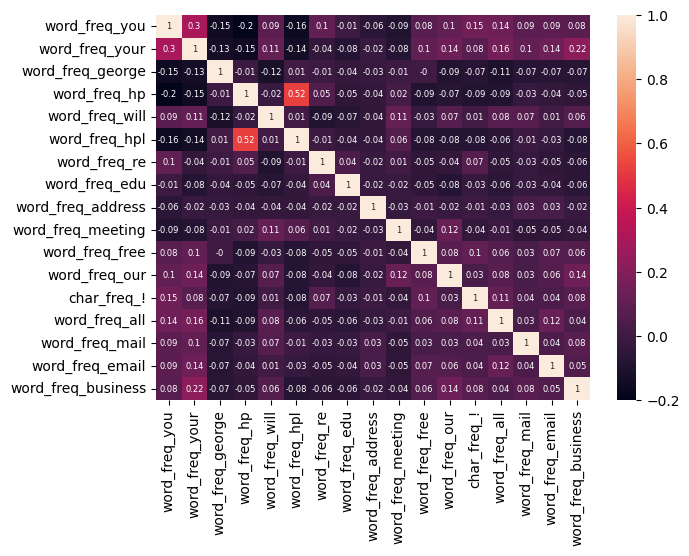

In [317]:
# Veamos la correlación cruzada
plt.figure(figsize=(7, 5))
default_profit = dataset[["word_freq_you","word_freq_your","word_freq_george","word_freq_hp","word_freq_will","word_freq_hpl","word_freq_re","word_freq_edu","word_freq_address","word_freq_meeting","word_freq_free","word_freq_our","char_freq_!","word_freq_all","word_freq_mail","word_freq_email","word_freq_business"]].corr(numeric_only=True).round(2)
sns.heatmap(data=default_profit, annot=True, annot_kws={"size": 6});

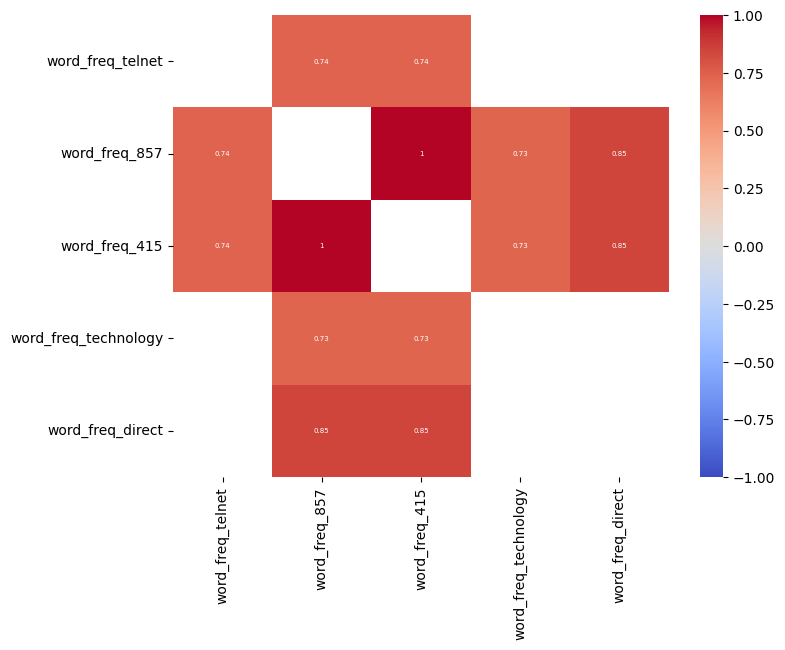

Index(['word_freq_telnet', 'word_freq_857', 'word_freq_415',
       'word_freq_technology', 'word_freq_direct'],
      dtype='object')


In [318]:
# Define the correlation threshold
threshold = 0.7

# Compute the correlation matrix
corr_matrix = dataset.corr()
filtered_corr = corr_matrix.where(np.abs(corr_matrix) > threshold)
# Drop rows and columns that are all NaN (below threshold)
np.fill_diagonal(filtered_corr.values, np.nan)
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 5}, mask=filtered_corr.isnull())

# Show the plot
plt.show()
print(filtered_corr.index)


#### 2. Separe el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba (70% y 30% respectivamente).

In [319]:
random_state = 12345 #Repetitibilidad en el split de los datos

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True)

display(dataset['spam'].value_counts())
display(y_train.value_counts())
display(y_test.value_counts())

spam
0    2788
1    1813
Name: count, dtype: int64

spam
0    1951
1    1269
Name: count, dtype: int64

spam
0    837
1    544
Name: count, dtype: int64

Escalamos para aplicar en regresión logística

In [321]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformamos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#### 3. Utilizando un clasificador de Bayes ingenuo, entrene con el conjunto de entrenamiento.

In [322]:
bayes_naive = MultinomialNB()
bayes_naive.fit(X_train, y_train)   #Entrenamos con los datos sin escalar.
print(f"Porcentaje de muestras bien clasificadas: {(bayes_naive.score(X_test, y_test)*100)}%")

Porcentaje de muestras bien clasificadas: 86.60391020999276%


In [323]:
y_test_pred_bn = bayes_naive.predict(X_test) 

In [324]:
df_compare = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_test_pred_bn})
df_compare = df_compare[df_compare['True Label'] != df_compare['Predicted Label']]
print(f"Cantidad de mal clasificados (0: no_spam | 1: spam): {df_compare['Predicted Label'].value_counts()}")

Cantidad de mal clasificados (0: no_spam | 1: spam): Predicted Label
1    163
0     22
Name: count, dtype: int64


#### 4. Utilizando un clasificador de Regresión Logística, entrene con el conjunto de entrenamiento (en este caso, normalice los datos).

In [325]:
regresion_logistica = LogisticRegression()
regresion_logistica.fit(X_train_scaled, y_train) #Entrenamos con los valores escalados

print(f"Porcentaje de muestras bien clasificadas: {(regresion_logistica.score(X_test, y_test)*100)}%")

Porcentaje de muestras bien clasificadas: 80.59377262853005%


In [326]:
y_test_pred_rl = regresion_logistica.predict(X_test_scaled)

#### 5. Calcule la matriz de confusión del conjunto de evaluación para ambos modelos. ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?

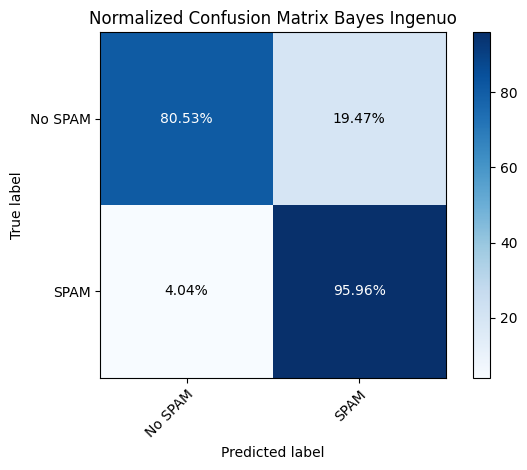

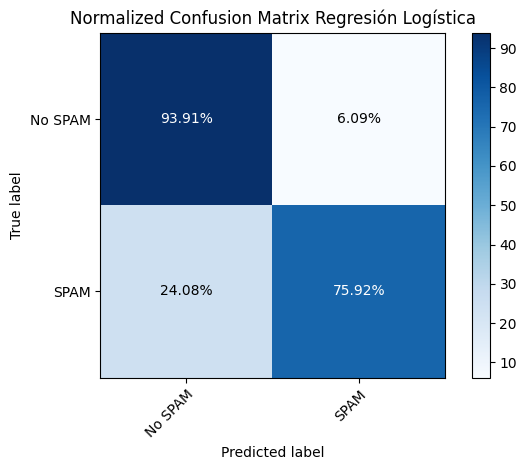

In [327]:
cm_nv = confusion_matrix(y_test, y_test_pred_bn)
cm_rl = confusion_matrix(y_test, y_test_pred_rl)

display_cm_normalized(cm_nv, 'Bayes Ingenuo')
display_cm_normalized(cm_rl, "Regresión Logística")

Para el caso de la matriz de confusión se toma por defecto valor True Positive al superior izquierdo. En este caso seria positivo los valores No SPAM que fueron clasificados como tal. 
1. Un Falso Positivo o error Tipo 1 en el contexto del problema son los correos No SPAM que fueron clasificados como SPAM. En el contexto del problema este es el peor caso, ya que se puede haber perdido un correo mal clasificado que era importante.
2. Un Falso Negativo o error Tipo 2 en el contexto del problema son los correos SPAM, que se clasificaron como No SPAM. En este contexto esto no es tan grave como perder mails importantes, ya que en todo caso se tienen algunos SPAM en la bandeja de entrada.

En este caso el mejor modelo es el Regresión Logística.

#### 6. Calcule la precisión y la recuperación de ambos modelos. Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.

In [328]:
from sklearn.metrics import precision_score, recall_score

print("------------------------------")
print("Modelo Bayes Ingenuo")
print(f"Precision: {precision_score(y_test, y_test_pred_bn, zero_division=0, pos_label=1)}")
print(f"Recuperación: {recall_score(y_test, y_test_pred_bn, zero_division=0, pos_label=1)}")
print("------------------------------")
print("Modelo Regresión Logística")
print(f"Precision: {precision_score(y_test, y_test_pred_rl, zero_division=0, pos_label=1)}")
print(f"Recuperación: {recall_score(y_test, y_test_pred_rl, zero_division=0, pos_label=1)}")

------------------------------
Modelo Bayes Ingenuo
Precision: 0.762043795620438
Recuperación: 0.9595588235294118
------------------------------
Modelo Regresión Logística
Precision: 0.8900862068965517
Recuperación: 0.7591911764705882


* Para el caso de los scores a nosotros nos interesa clasificar como positivo a los valores de SPAM con pos_label=1
    * La precisión es intuitivamente la capacidad del clasificador de no etiquetar como positiva una muestra que es negativa.
    * La recuperación es intuitivamente la capacidad del clasificador de encontrar todas las muestras positivas.

* El modelo de Regresión Logística muestra mejor precisión, lo que se veía en la matriz de confusión, ya que clasifica menos mail No SPAM como SPAM.
* El modelo de Bayes Ingenuo entrenado con los datos sin escalar parece ser mejor en clasificar los mails como SPAM en general.


#### 7. Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.

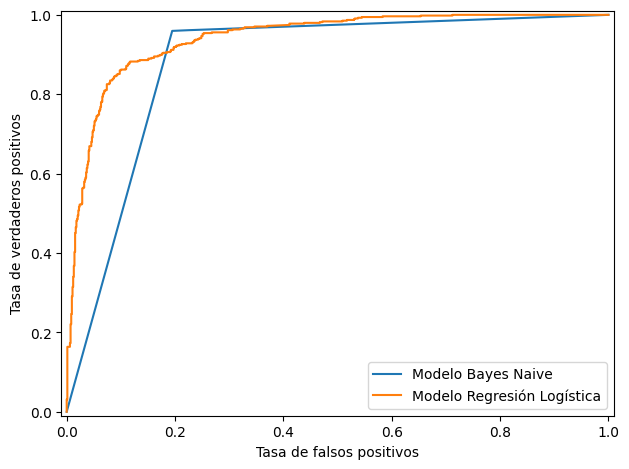

In [329]:
from sklearn.metrics import auc, roc_curve

prob_nv = bayes_naive.predict_proba(X_test)[:, -1]
prob_lv = regresion_logistica.predict_proba(X_test_scaled)[:, -1]

fpr_bayes_naive, tpr_bayes_naive, _ = roc_curve(y_test, prob_nv)
fpr_regresion_logistica, tpr_regresion_logistica, _ = roc_curve(y_test, prob_lv)

plt.plot(fpr_bayes_naive, tpr_bayes_naive, label="Modelo Bayes Naive")
plt.plot(fpr_regresion_logistica, tpr_regresion_logistica, label="Modelo Regresión Logística")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

La curva ROC nos permite ver para todo valor de umbral, los dos tipos de errores. En el eje de las abscisas se utiliza la tasa de falsos positivos (o 1-especificidad) y en la ordenada la tasa de verdadero positivos (sensibilidad).\
La curva se obtiene midiendo la sensibilidad y la especificad para todos los valores de umbrales de 0 a 1.

In [330]:
print(f"Modelo Bayes Ingenuo AUC: {auc(fpr_bayes_naive, tpr_bayes_naive)}")
print(f"Modelo Regresión Logística AUC: {auc(fpr_regresion_logistica, tpr_regresion_logistica)}")

Modelo Bayes Ingenuo AUC: 0.8825198538196641
Modelo Regresión Logística AUC: 0.9409282978424346


El modelo de Regresión Logística con los datos escalados funciona mejor según la AUC, tiene mejor poder de clasificación.

# Modificando el dataset

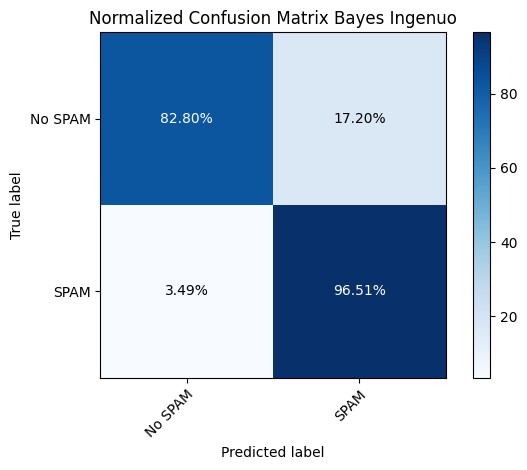

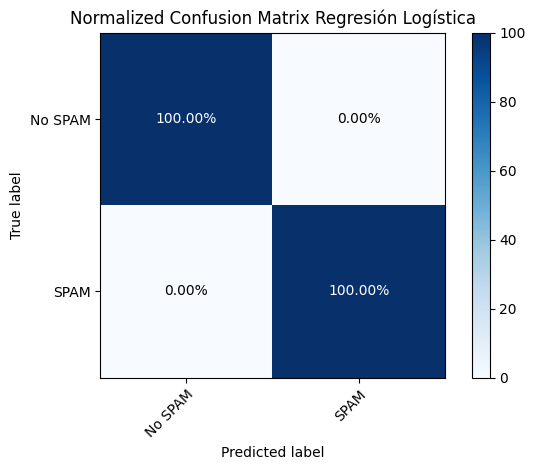

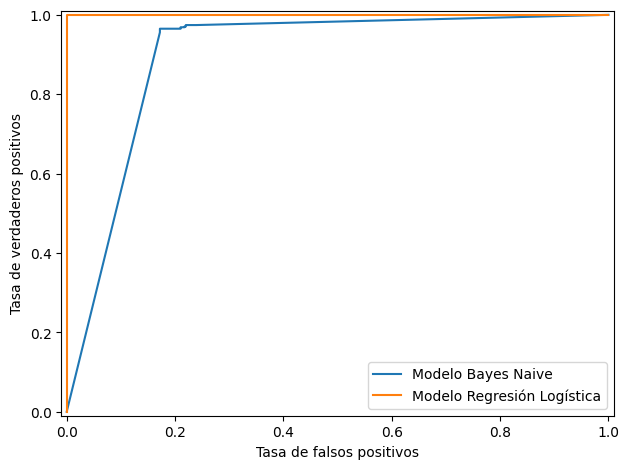

In [334]:
dataset = pd.read_csv("dataset/spambase.csv") # cargando los datos desde un CSV
X = dataset.drop(columns=["word_freq_you", "word_freq_your"])
y = X["spam"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

bayes_naive1 = MultinomialNB()
regresion_logistica1 = LogisticRegression()
bayes_naive1.fit(X_train, y_train)
regresion_logistica1.fit(X_train_scaled, y_train)

y_test_pred_bn = bayes_naive1.predict(X_test)
y_test_pred_rl = regresion_logistica1.predict(X_test_scaled)

cm_nv = confusion_matrix(y_test, y_test_pred_bn)
cm_rl = confusion_matrix(y_test, y_test_pred_rl)

display_cm_normalized(cm_nv, 'Bayes Ingenuo')
display_cm_normalized(cm_rl, "Regresión Logística")

prob_nv = bayes_naive1.predict_proba(X_test)[:, -1]
prob_lv = regresion_logistica1.predict_proba(X_test_scaled)[:, -1]

fpr_bayes_naive, tpr_bayes_naive, _ = roc_curve(y_test, prob_nv)
fpr_regresion_logistica, tpr_regresion_logistica, _ = roc_curve(y_test, prob_lv)

plt.plot(fpr_bayes_naive, tpr_bayes_naive, label="Modelo Bayes Naive")
plt.plot(fpr_regresion_logistica, tpr_regresion_logistica, label="Modelo Regresión Logística")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

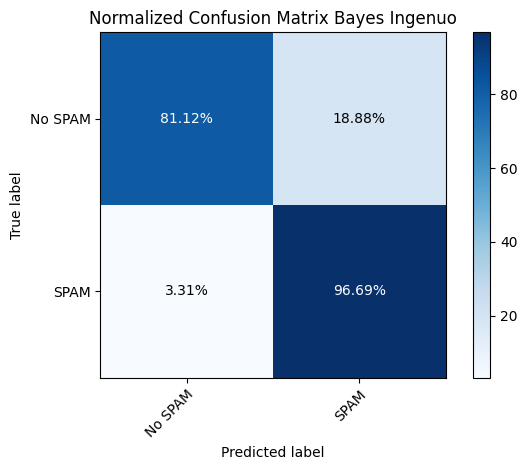

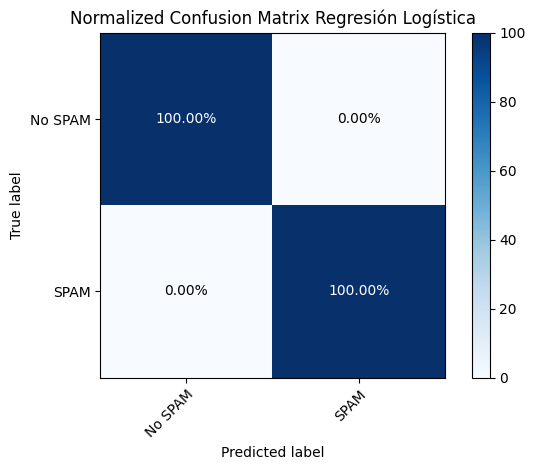

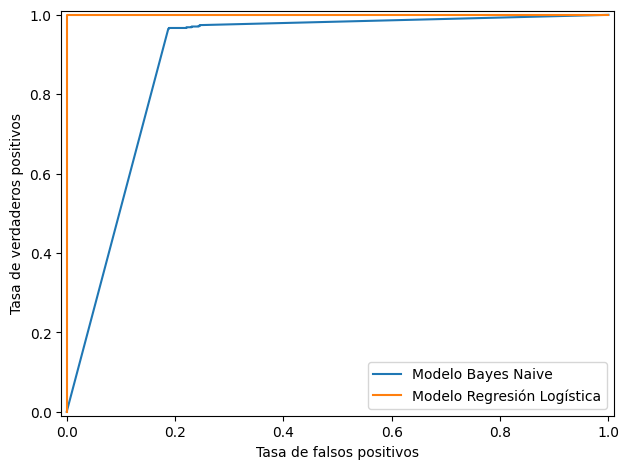

In [335]:
dataset = pd.read_csv("dataset/spambase.csv") # cargando los datos desde un CSV
X = dataset.drop(columns=['word_freq_telnet', 'word_freq_857', 'word_freq_415','word_freq_technology', 'word_freq_direct'])
y = X["spam"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

bayes_naive2 = MultinomialNB()
regresion_logistica2 = LogisticRegression()
bayes_naive2.fit(X_train, y_train)
regresion_logistica2.fit(X_train_scaled, y_train)

y_test_pred_bn = bayes_naive2.predict(X_test)
y_test_pred_rl = regresion_logistica2.predict(X_test_scaled)

cm_nv = confusion_matrix(y_test, y_test_pred_bn)
cm_rl = confusion_matrix(y_test, y_test_pred_rl)

display_cm_normalized(cm_nv, 'Bayes Ingenuo')
display_cm_normalized(cm_rl, "Regresión Logística")

prob_nv = bayes_naive2.predict_proba(X_test)[:, -1]
prob_lv = regresion_logistica2.predict_proba(X_test_scaled)[:, -1]

fpr_bayes_naive, tpr_bayes_naive, _ = roc_curve(y_test, prob_nv)
fpr_regresion_logistica, tpr_regresion_logistica, _ = roc_curve(y_test, prob_lv)

plt.plot(fpr_bayes_naive, tpr_bayes_naive, label="Modelo Bayes Naive")
plt.plot(fpr_regresion_logistica, tpr_regresion_logistica, label="Modelo Regresión Logística")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();